In [ ]:
# Install talib for technical indicators
# %%capture will suppress all output - these commands produce way too many
#   output statments
%%capture
! wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
! tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
! ./configure --prefix=/usr
! make
! make install
! pip install Ta-Lib

In [ ]:
! pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 2.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


### Imports and file path

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import talib
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPool2D, concatenate, Activation, add, AveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import Model
import json
import time
from collections import deque
import warnings
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

file_path = '/content/drive/My Drive/Forex_Robot/'

In [35]:
# Mount google drive for accessing files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read in and clean/prepare data

In [36]:
df = pd.read_csv(file_path + 'Oanda_Eur_Usd_M30_expanded.csv')
df.Date = pd.to_datetime(df.Date)
df.reset_index(drop=True, inplace=True)

df

,Date,Bid_Open,Bid_High,Bid_Low,Bid_Close,Ask_Open,Ask_High,Ask_Low,Ask_Close,Nonfarm_Payroll_Actual,Nonfarm_Payroll_Forecast,Nonfarm_Payroll_Previous
0,2008-03-09 18:00:00,1.53457,1.53472,1.53452,1.53472,1.53557,1.53572,1.53552,1.53572,-63000,25000,-17000
1,2008-03-09 19:00:00,1.53462,1.53522,1.53462,1.53507,1.53562,1.53622,1.53562,1.53607,-63000,25000,-17000
2,2008-03-09 19:30:00,1.53517,1.53517,1.53477,1.53487,1.53617,1.53617,1.53577,1.53587,-63000,25000,-17000
3,2008-03-09 20:00:00,1.53487,1.53497,1.53482,1.53492,1.53587,1.53597,1.53582,1.53592,-63000,25000,-17000
4,2008-03-09 20:30:00,1.53492,1.53587,1.53492,1.53582,1.53592,1.53687,1.53592,1.53682,-63000,25000,-17000
...,...,...,...,...,...,...,...,...,...,...,...,...
158883,2020-10-07 21:30:00,1.17632,1.17640,1.17609,1.17615,1.17672,1.17724,1.17665,1.17687,661000,850000,1489000
158884,2020-10-07 22:00:00,1.17623,1.17698,1.17623,1.17698,1.17688,1.17723,1.17678,1.17715,661000,850000,1489000
158885,2020-10-07 22:30:00,1.17698,1.17698,1.17676,1.17676,1.17715,1.17715,1.17692,1.17692,661000,850000,1489000
158886,2020-10-07 23:00:00,1.17677,1.17688,1.17655,1.17657,1.17695,1.17702,1.17670,1.17673,661000,850000,1489000


,Date,Bid_Open,Bid_High,Bid_Low,Bid_Close,Ask_Open,Ask_High,Ask_Low,Ask_Close,Nonfarm_Payroll_Actual,Nonfarm_Payroll_Forecast,Nonfarm_Payroll_Previous,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month
0,2008-03-09 18:00:00,1.53457,1.53472,1.53452,1.53472,1.53557,1.53572,1.53552,1.53572,-63000,25000,-17000,-1.000000,-1.836970e-16,0.974928,-0.222521,1.0,6.123234e-17
1,2008-03-09 19:00:00,1.53462,1.53522,1.53462,1.53507,1.53562,1.53622,1.53562,1.53607,-63000,25000,-17000,-0.965926,2.588190e-01,0.974928,-0.222521,1.0,6.123234e-17
2,2008-03-09 19:30:00,1.53517,1.53517,1.53477,1.53487,1.53617,1.53617,1.53577,1.53587,-63000,25000,-17000,-0.965926,2.588190e-01,0.974928,-0.222521,1.0,6.123234e-17
3,2008-03-09 20:00:00,1.53487,1.53497,1.53482,1.53492,1.53587,1.53597,1.53582,1.53592,-63000,25000,-17000,-0.866025,5.000000e-01,0.974928,-0.222521,1.0,6.123234e-17
4,2008-03-09 20:30:00,1.53492,1.53587,1.53492,1.53582,1.53592,1.53687,1.53592,1.53682,-63000,25000,-17000,-0.866025,5.000000e-01,0.974928,-0.222521,1.0,6.123234e-17


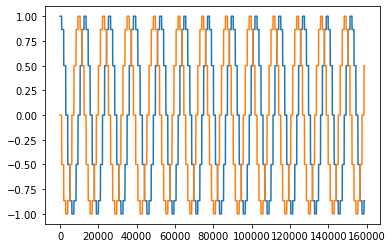

In [37]:
# Add hour of day, day of week, and month of year (for additional features)
# Use sine and cosine to keep the cyclic nature of hour, day, and month
#  (December is closer to January than October, midnight is closer to 1 am than
#  10 pm, etc.)
df['sin_hour'] = np.sin(2 * np.pi * df['Date'].dt.hour / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Date'].dt.hour / 24)
df['sin_day'] = np.sin(2 * np.pi * df['Date'].dt.day / 7)
df['cos_day'] = np.cos(2 * np.pi * df['Date'].dt.day / 7)
df['sin_month'] = np.sin(2 * np.pi * df['Date'].dt.month / 12)
df['cos_month'] = np.cos(2 * np.pi * df['Date'].dt.month / 12)

# Plots to illustrate cyclic nature of time
df.sin_month.plot()
df.cos_month.plot()

# Show the updated dataframe
df.head()

In [38]:
# Add technical indicators (for additional features)
# Bid technical indicators
df['Bid_SMA1'] = talib.SMA(df['Bid_Close'], timeperiod=10)
df['Bid_SMA1_Envelope_Upper'] = df['Bid_SMA1'] + (0.1 * df['Bid_SMA1'])
df['Bid_SMA1_Envelope_Lower'] = df['Bid_SMA1'] - (0.1 * df['Bid_SMA1'])
df['Bid_EMA1'] = talib.EMA(df['Bid_Close'], timeperiod=10)
df['Bid_EMA1_Envelope_Upper'] = df['Bid_EMA1'] + (0.1 * df['Bid_EMA1'])
df['Bid_EMA1_Envelope_Lower'] = df['Bid_EMA1'] - (0.1 * df['Bid_EMA1'])
df['Bid_SMA2'] = talib.SMA(df['Bid_Close'], timeperiod=20)
df['Bid_SMA2_Envelope_Upper'] = df['Bid_SMA2'] + (0.1 * df['Bid_SMA2'])
df['Bid_SMA2_Envelope_Lower'] = df['Bid_SMA2'] - (0.1 * df['Bid_SMA2'])
df['Bid_EMA2'] = talib.EMA(df['Bid_Close'], timeperiod=20)
df['Bid_EMA2_Envelope_Upper'] = df['Bid_EMA2'] + (0.1 * df['Bid_EMA2'])
df['Bid_EMA2_Envelope_Lower'] = df['Bid_EMA2'] - (0.1 * df['Bid_EMA2'])
df['Bid_SMA3'] = talib.SMA(df['Bid_Close'], timeperiod=30)
df['Bid_SMA3_Envelope_Upper'] = df['Bid_SMA3'] + (0.1 * df['Bid_SMA3'])
df['Bid_SMA3_Envelope_Lower'] = df['Bid_SMA3'] - (0.1 * df['Bid_SMA3'])
df['Bid_EMA3'] = talib.EMA(df['Bid_Close'], timeperiod=30)
df['Bid_EMA3_Envelope_Upper'] = df['Bid_EMA3'] + (0.1 * df['Bid_EMA3'])
df['Bid_EMA3_Envelope_Lower'] = df['Bid_EMA3'] - (0.1 * df['Bid_EMA3'])
df['Bid_BB_Upper_Band'], df['Bid_BB_Middle_Band'], df['Bid_BB_Lower_Band'] = talib.BBANDS(
    df['Bid_Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['Bid_MACD'], df['Bid_MACD_Signal'], df['Bid_MACD_hist'] = talib.MACD(df['Bid_Close'],
                                                            fastperiod=12,
                                                            slowperiod=26,
                                                            signalperiod=9)
df['Bid_Parabollic_SAR'] = talib.SAR(df['Bid_High'], df['Bid_Low'], acceleration=0, maximum=0)
df['Bid_Slowk'], df['Bid_Slowd'] = talib.STOCH(df['Bid_High'], df['Bid_Low'], df['Bid_Close'],
                                       fastk_period=5, slowk_period=3,
                                       slowk_matype=0, slowd_period=3,
                                       slowd_matype=0)
df['Bid_RSI'] = talib.RSI(df['Bid_Close'], timeperiod=14)
df['Bid_Williams_Percent_Range'] = talib.WILLR(df['Bid_High'], df['Bid_Low'], df['Bid_Close'],
                                           timeperiod=14)
df['Bid_ADX'] = talib.ADX(df['Bid_High'], df['Bid_Low'], df['Bid_Close'], timeperiod=14)
df['Bid_ADXR'] = talib.ADXR(df['Bid_High'], df['Bid_Low'], df['Bid_Close'], timeperiod=14)
df['Bid_MOM'] = talib.MOM(df['Bid_Close'], timeperiod=10)
df['Bid_BOP'] = talib.BOP(df['Bid_Open'], df['Bid_High'], df['Bid_Low'], df['Bid_Close'])
df['Bid_AROONOSC'] = talib.AROONOSC(df['Bid_High'], df['Bid_Low'], timeperiod=14)
df['Bid_ATR'] = talib.ATR(df['Bid_High'], df['Bid_Low'], df['Bid_Close'], timeperiod=14)

# Ask technical indicators
df['Ask_SMA1'] = talib.SMA(df['Ask_Close'], timeperiod=10)
df['Ask_SMA1_Envelope_Upper'] = df['Ask_SMA1'] + (0.1 * df['Ask_SMA1'])
df['Ask_SMA1_Envelope_Lower'] = df['Ask_SMA1'] - (0.1 * df['Ask_SMA1'])
df['Ask_EMA1'] = talib.EMA(df['Ask_Close'], timeperiod=10)
df['Ask_EMA1_Envelope_Upper'] = df['Ask_EMA1'] + (0.1 * df['Ask_EMA1'])
df['Ask_EMA1_Envelope_Lower'] = df['Ask_EMA1'] - (0.1 * df['Ask_EMA1'])
df['Ask_SMA2'] = talib.SMA(df['Ask_Close'], timeperiod=20)
df['Ask_SMA2_Envelope_Upper'] = df['Ask_SMA2'] + (0.1 * df['Ask_SMA2'])
df['Ask_SMA2_Envelope_Lower'] = df['Ask_SMA2'] - (0.1 * df['Ask_SMA2'])
df['Ask_EMA2'] = talib.EMA(df['Ask_Close'], timeperiod=20)
df['Ask_EMA2_Envelope_Upper'] = df['Ask_EMA2'] + (0.1 * df['Ask_EMA2'])
df['Ask_EMA2_Envelope_Lower'] = df['Ask_EMA2'] - (0.1 * df['Ask_EMA2'])
df['Ask_SMA3'] = talib.SMA(df['Ask_Close'], timeperiod=30)
df['Ask_SMA3_Envelope_Upper'] = df['Ask_SMA3'] + (0.1 * df['Ask_SMA3'])
df['Ask_SMA3_Envelope_Lower'] = df['Ask_SMA3'] - (0.1 * df['Ask_SMA3'])
df['Ask_EMA3'] = talib.EMA(df['Ask_Close'], timeperiod=30)
df['Ask_EMA3_Envelope_Upper'] = df['Ask_EMA3'] + (0.1 * df['Ask_EMA3'])
df['Ask_EMA3_Envelope_Lower'] = df['Ask_EMA3'] - (0.1 * df['Ask_EMA3'])
df['Ask_BB_Upper_Band'], df['Ask_BB_Middle_Band'], df['Ask_BB_Lower_Band'] = talib.BBANDS(
    df['Ask_Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['Ask_MACD'], df['Ask_MACD_Signal'], df['Ask_MACD_hist'] = talib.MACD(df['Ask_Close'],
                                                            fastperiod=12,
                                                            slowperiod=26,
                                                            signalperiod=9)
df['Ask_Parabollic_SAR'] = talib.SAR(df['Ask_High'], df['Ask_Low'], acceleration=0, maximum=0)
df['Ask_Slowk'], df['Ask_Slowd'] = talib.STOCH(df['Ask_High'], df['Ask_Low'], df['Ask_Close'],
                                       fastk_period=5, slowk_period=3,
                                       slowk_matype=0, slowd_period=3,
                                       slowd_matype=0)
df['Ask_RSI'] = talib.RSI(df['Ask_Close'], timeperiod=14)
df['Ask_Williams_Percent_Range'] = talib.WILLR(df['Ask_High'], df['Ask_Low'], df['Ask_Close'],
                                           timeperiod=14)
df['Ask_ADX'] = talib.ADX(df['Ask_High'], df['Ask_Low'], df['Ask_Close'], timeperiod=14)
df['Ask_ADXR'] = talib.ADXR(df['Ask_High'], df['Ask_Low'], df['Ask_Close'], timeperiod=14)
df['Ask_MOM'] = talib.MOM(df['Ask_Close'], timeperiod=10)
df['Ask_BOP'] = talib.BOP(df['Ask_Open'], df['Ask_High'], df['Ask_Low'], df['Ask_Close'])
df['Ask_AROONOSC'] = talib.AROONOSC(df['Ask_High'], df['Ask_Low'], timeperiod=14)
df['Ask_ATR'] = talib.ATR(df['Ask_High'], df['Ask_Low'], df['Ask_Close'], timeperiod=14)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Store the original dates in a separate column - used in the trading environment
dates = df['Date']

# Drop the original date column (it is no longer needed)
df.drop('Date', axis=1, inplace=True)

df

,Bid_Open,Bid_High,Bid_Low,Bid_Close,Ask_Open,Ask_High,Ask_Low,Ask_Close,Nonfarm_Payroll_Actual,Nonfarm_Payroll_Forecast,Nonfarm_Payroll_Previous,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month,Bid_SMA1,Bid_SMA1_Envelope_Upper,Bid_SMA1_Envelope_Lower,Bid_EMA1,Bid_EMA1_Envelope_Upper,Bid_EMA1_Envelope_Lower,Bid_SMA2,Bid_SMA2_Envelope_Upper,Bid_SMA2_Envelope_Lower,Bid_EMA2,Bid_EMA2_Envelope_Upper,Bid_EMA2_Envelope_Lower,Bid_SMA3,Bid_SMA3_Envelope_Upper,Bid_SMA3_Envelope_Lower,Bid_EMA3,Bid_EMA3_Envelope_Upper,Bid_EMA3_Envelope_Lower,Bid_BB_Upper_Band,Bid_BB_Middle_Band,Bid_BB_Lower_Band,Bid_MACD,Bid_MACD_Signal,...,Bid_ADXR,Bid_MOM,Bid_BOP,Bid_AROONOSC,Bid_ATR,Ask_SMA1,Ask_SMA1_Envelope_Upper,Ask_SMA1_Envelope_Lower,Ask_EMA1,Ask_EMA1_Envelope_Upper,Ask_EMA1_Envelope_Lower,Ask_SMA2,Ask_SMA2_Envelope_Upper,Ask_SMA2_Envelope_Lower,Ask_EMA2,Ask_EMA2_Envelope_Upper,Ask_EMA2_Envelope_Lower,Ask_SMA3,Ask_SMA3_Envelope_Upper,Ask_SMA3_Envelope_Lower,Ask_EMA3,Ask_EMA3_Envelope_Upper,Ask_EMA3_Envelope_Lower,Ask_BB_Upper_Band,Ask_BB_Middle_Band,Ask_BB_Lower_Band,Ask_MACD,Ask_MACD_Signal,Ask_MACD_hist,Ask_Parabollic_SAR,Ask_Slowk,Ask_Slowd,Ask_RSI,Ask_Williams_Percent_Range,Ask_ADX,Ask_ADXR,Ask_MOM,Ask_BOP,Ask_AROONOSC,Ask_ATR
0,1.53464,1.53594,1.53444,1.53554,1.53473,1.53603,1.53453,1.53563,-63000,25000,-17000,-0.500000,-0.866025,4.338837e-01,-0.900969,1.000000,6.123234e-17,1.535374,1.688911,1.381837,1.535436,1.688979,1.381892,1.536795,1.690475,1.383116,1.536172,1.689790,1.382555,1.537330,1.691063,1.383597,1.536480,1.690128,1.382832,1.535930,1.534466,1.533002,-0.000726,-0.000375,...,34.005521,-0.00234,0.600000,-71.428571,0.001605,1.535464,1.689010,1.381918,1.535533,1.689086,1.381980,1.536913,1.690604,1.383221,1.536341,1.689975,1.382707,1.537475,1.691222,1.383727,1.536756,1.690432,1.383081,1.536020,1.534556,1.533092,-0.000858,-0.000555,-0.000303,1.54101,65.733075,53.825443,45.630459,-44.575163,28.203452,27.079807,-0.00234,0.600000,-71.428571,0.001612
1,1.53564,1.53744,1.53544,1.53719,1.53573,1.53753,1.53553,1.53728,-63000,25000,-17000,-0.707107,-0.707107,4.338837e-01,-0.900969,1.000000,6.123234e-17,1.535370,1.688907,1.381833,1.535755,1.689330,1.382179,1.536716,1.690388,1.383044,1.536269,1.689896,1.382642,1.537279,1.691007,1.383551,1.536525,1.690178,1.382873,1.537609,1.534950,1.532291,-0.000548,-0.000410,...,32.190140,-0.00004,0.775000,-64.285714,0.001633,1.535460,1.689006,1.381914,1.535851,1.689436,1.382266,1.536828,1.690511,1.383145,1.536430,1.690073,1.382787,1.537420,1.691162,1.383678,1.536790,1.690469,1.383111,1.537699,1.535040,1.532381,-0.000672,-0.000578,-0.000093,1.54101,81.699258,65.400367,54.077847,-21.045576,27.150034,25.627767,-0.00004,0.775000,-64.285714,0.001640
2,1.53719,1.53764,1.53643,1.53691,1.53728,1.53773,1.53652,1.53700,-63000,25000,-17000,-0.707107,-0.707107,4.338837e-01,-0.900969,1.000000,6.123234e-17,1.535457,1.689003,1.381911,1.535965,1.689561,1.382368,1.536706,1.690376,1.383035,1.536330,1.689963,1.382697,1.537235,1.690959,1.383512,1.536550,1.690205,1.382895,1.538172,1.535644,1.533116,-0.000425,-0.000413,...,30.775606,0.00087,-0.231405,-50.000000,0.001603,1.535547,1.689102,1.381992,1.536060,1.689666,1.382454,1.536812,1.690493,1.383131,1.536484,1.690133,1.382836,1.537373,1.691110,1.383636,1.536804,1.690484,1.383123,1.538262,1.535734,1.533206,-0.000540,-0.000571,0.000031,1.54101,89.602787,79.011707,52.584759,-24.798928,26.025441,24.553161,0.00087,-0.231405,-50.000000,0.001609
3,1.53681,1.53761,1.53356,1.53366,1.53690,1.53770,1.53365,1.53375,-63000,25000,-17000,-0.866025,-0.500000,4.338837e-01,-0.900969,1.000000,6.123234e-17,1.535184,1.688702,1.381666,1.535546,1.689100,1.381991,1.536503,1.690153,1.382852,1.536076,1.689684,1.382468,1.537077,1.690784,1.383369,1.536364,1.690000,1.382727,1.538257,1.535598,1.532939,-0.000583,-0.000447,...,30.167115,-0.00273,-0.777778,-50.000000,0.001778,1.535274,1.688801,1.381747,1.535640,1.689204,1.382076,1.536604,1.690264,1.382943,1.536224,1.689846,1.382602,1.537211,1.690932,1.383490,1.5

### Forex Account Details

In [39]:
account_balance = 5000
percent_to_risk = 0.02
pips_to_risk = 50
risk_reward_ratio = 2
n_units_per_trade = 10000
value_per_pip = n_units_per_trade * 0.0001

if ((value_per_pip * pips_to_risk) / account_balance) > percent_to_risk:
  print('To much money risked per trade -- change parameters')

pips_to_risk /= 10000

### Functions for grabbing subsets of data

In [40]:
def create_target(dataset, i, pred_period=4):
  curr_bid_open = dataset.loc[dataset.index[i], 'Bid_Open']
  curr_ask_open = dataset.loc[dataset.index[i], 'Ask_Open']
  sell_stop_loss = curr_bid_open + pips_to_risk
  sell_stop_gain = curr_bid_open - (risk_reward_ratio * pips_to_risk)
  buy_stop_loss = curr_ask_open - pips_to_risk
  buy_stop_gain = curr_ask_open + (risk_reward_ratio * pips_to_risk)
  tmp = i
  j = 0
  buy = False
  sell = False

  # Assume a buy
  while i < dataset.shape[0] and j < pred_period:
    curr_bid_high = dataset.loc[dataset.index[i], 'Bid_High']
    curr_bid_low = dataset.loc[dataset.index[i], 'Bid_Low']

    if curr_bid_low <= buy_stop_loss:
      break

    # if curr_bid_high >= curr_ask_open + pips_to_risk:
    #   buy_stop_loss = curr_ask_open
    if curr_bid_high - pips_to_risk >= buy_stop_loss:
      buy_stop_loss = curr_bid_high - pips_to_risk

    if curr_bid_high >= buy_stop_gain:
      buy = True
      break

    i += 1
    j += 1

  i = tmp
  j = 0

  # Assume a sell
  while i < dataset.shape[0] and j < pred_period:
    curr_ask_high = dataset.loc[dataset.index[i], 'Ask_High']
    curr_ask_low = dataset.loc[dataset.index[i], 'Ask_Low']

    if curr_ask_high >= sell_stop_loss:
      break

    # if curr_ask_low <= curr_bid_open - pips_to_risk:
    #   sell_stop_loss = curr_bid_open
    if curr_ask_low + pips_to_risk <= sell_stop_loss:
      sell_stop_loss = curr_ask_low + pips_to_risk

    if curr_ask_low <= sell_stop_gain:
      sell = True
      break

    i += 1
    j += 1

  if buy and sell:
    print('wtf')
    print(i)
    print()
    return 0

  elif buy:
    return 1

  elif sell:
    return 2

  else:
    return 0

In [41]:
df['target'] = [create_target(df, i) for i in range(df.shape[0])]

In [42]:
df['target'].value_counts()

0    157427
2       724
1       697
Name: target, dtype: int64

In [43]:
def get_sequential_data(input_df):
    sequential_data = []
    prev_data = deque(maxlen=60)

    for i in range(input_df.shape[0] - 1):
        row = input_df.iloc[i, :]
        prev_data.append([val for val in row[:-1]])

        if len(prev_data) == 60:
          target = input_df.iloc[i + 1, -1]
          sequential_data.append([np.array(prev_data), target])

    np.random.shuffle(sequential_data)

    no_actions = []
    buys = []
    sells = []

    for seq, target in sequential_data:
        if target == 0 :
          no_actions.append([seq, np.array([1, 0, 0])])

        elif target == 1:
          buys.append([seq, np.array([0, 1, 0])])

        elif target == 2:
          sells.append([seq, np.array([0, 0, 1])])

    np.random.shuffle(no_actions)
    np.random.shuffle(buys)
    np.random.shuffle(sells)

    lower = min(len(no_actions), len(buys), len(sells))

    no_actions = no_actions[:int(lower * 1.5)]
    # buys = buys[:lower]
    # sells = sells[:lower]

    sequential_data = no_actions + buys + sells
    np.random.shuffle(sequential_data)

    return sequential_data

In [44]:
# training_proportion = 0.6
# train_test_cutoff_index = int(df.shape[0] * training_proportion)
# train_set = df.iloc[:train_test_cutoff_index, :]
# train_set.reset_index(drop=True, inplace=True)
# test_set = df.iloc[train_test_cutoff_index:, :]
# test_set.reset_index(drop=True, inplace=True)

In [45]:
# train_set['target'].value_counts()

In [46]:
# test_set['target'].value_counts()

In [47]:
# dates[df.shape[0] - 7000]
# dates[df.shape[0] - 1300]
dates[df.shape[0] - 250]

Timestamp('2020-09-30 18:00:00')

In [48]:
# test_df = df.iloc[df.shape[0] - 7000:, :]
# test_df = df.iloc[df.shape[0] - 1300:, :]
test_df = df.iloc[df.shape[0] - 250:, :]
test_df.reset_index(drop=True, inplace=True)
# df = df.iloc[0:df.shape[0] - 7000, :]
# df = df.iloc[0:df.shape[0] - 1300, :]
df = df.iloc[0:df.shape[0] - 250, :]
df.reset_index(drop=True, inplace=True)

In [49]:
# sequential_train_set = get_sequential_data(train_set)
# sequential_test_set = get_sequential_data(test_set)

sequential_data = get_sequential_data(df)

In [50]:
training_proportion = 0.7
train_test_cutoff_index = int(len(sequential_data) * training_proportion)

train_set = sequential_data[0:train_test_cutoff_index]
test_set = sequential_data[train_test_cutoff_index:]

print('Dataset shapes:')
print(len(train_set))
print(len(test_set))

Dataset shapes:
1721
738


In [51]:
x_train = []
y_train = []

for seq, target in train_set:
  x_train.append(seq)
  y_train.append(target)

x_test = []
y_test = []

for seq, target in test_set:
  x_test.append(seq)
  y_test.append(target)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# x_train = []
# y_train = []

# for seq, target in sequential_train_set:
#   x_train.append(seq)
#   y_train.append(target)

# x_test = []
# y_test = []

# for seq, target in sequential_test_set:
#   x_test.append(seq)
#   y_test.append(target)

# x_train = np.array(x_train)
# y_train = np.array(y_train)
# x_test = np.array(x_test)
# y_test = np.array(y_test)

In [52]:
n_sequences, n_rows, n_cols = x_train.shape
scaler = StandardScaler()

x_train = x_train.reshape(-1, n_cols)
x_train = scaler.fit_transform(x_train)
x_train = x_train.reshape(-1, n_rows, n_cols)

x_test = x_test.reshape(-1, n_cols)
x_test = scaler.transform(x_test)
x_test = x_test.reshape(-1, n_rows, n_cols)

dump(scaler, open(file_path + 'rnn/scalers/eur_usd_rnn_scaler.pkl', 'wb'))

### Training

In [53]:
# Hyperparameters
n_epochs = 100
batch_size = 32

In [54]:
# RNN
eur_usd_rnn = Sequential()

eur_usd_rnn.add(GRU(128, return_sequences=True))
eur_usd_rnn.add(Dropout(0.2))
eur_usd_rnn.add(BatchNormalization())

eur_usd_rnn.add(GRU(128, return_sequences=True))
eur_usd_rnn.add(Dropout(0.1))
eur_usd_rnn.add(BatchNormalization())

eur_usd_rnn.add(GRU(128))
eur_usd_rnn.add(Dropout(0.2))
eur_usd_rnn.add(BatchNormalization())

eur_usd_rnn.add(Dense(32, activation='relu'))
eur_usd_rnn.add(Dropout(0.2))

eur_usd_rnn.add(Dense(3, activation='softmax'))

In [55]:
early_stop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=100)
model_checkpoint = ModelCheckpoint(file_path + 'rnn/rnns/eur_usd_rnn.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
optimizer = Adam()

eur_usd_rnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [56]:
history = eur_usd_rnn.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 1.1492 - accuracy: 0.5044
Epoch 00001: val_accuracy improved from -inf to 0.52846, saving model to /content/drive/My Drive/Forex_Robot/rnn/rnns/eur_usd_rnn.h5
54/54 [==============================] - 12s 214ms/step - loss: 1.1492 - accuracy: 0.5044 - val_loss: 0.9464 - val_accuracy: 0.5285
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 0.9615 - accuracy: 0.5555
Epoch 00002: val_accuracy improved from 0.52846 to 0.57724, saving model to /content/drive/My Drive/Forex_Robot/rnn/rnns/eur_usd_rnn.h5
54/54 [==============================] - 11s 205ms/step - loss: 0.9615 - accuracy: 0.5555 - val_loss: 0.9198 - val_accuracy: 0.5772
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 0.9229 - accuracy: 0.5834
Epoch 00003: val_accuracy did not improve from 0.57724
54/54 [==============================] - 11s 202ms/step - loss: 0.9229 - accuracy: 0.5834 - val_loss: 0.9052 - val_accuracy: 0.

In [57]:
eur_usd_rnn = load_model(file_path + 'rnn/rnns/eur_usd_rnn.h5')

In [58]:
test_df = test_df.iloc[:, 0:-1]

In [59]:
scaler = load(open(file_path + 'rnn/scalers/eur_usd_rnn_scaler.pkl', 'rb'))
test_df = scaler.transform(test_df)

In [60]:
test_df.shape

(250, 87)

In [61]:
test_df_sequences = deque(maxlen=60)

for i in range(0, 60):
  test_df_sequences.append(test_df[i, :])

reward = 0
n_wins = 0
n_losses = 0
win_streak = 0
loss_streak = 0
curr_win_streak = 0
curr_loss_streak = 0
n_buys = 0
n_sells = 0
trade_len = 0
trade_len_divider = 2 * 24
trade_lens = []
longest_trade = 0
trade = None
open_price = None
stop_gain = None
stop_loss = None

for i in range(60, test_df.shape[0]):
  if account_balance + reward < 0:
    print(account_balance + reward)
    
  curr_seq = np.array(test_df_sequences)
  bid_open, bid_high, bid_low, bid_close, ask_open, ask_high, ask_low, ask_close = test_df[i, 0:8]

  if trade is None:
    pred = eur_usd_rnn.predict(curr_seq.reshape(1, 60, 87))
    argmax = np.argmax(pred)
    proba = pred[0][argmax]

    if argmax == 1 and proba >= 0.6:
      trade = 'buy'
      open_price = float(round(ask_open, 5))
      stop_gain = round(open_price + (risk_reward_ratio * pips_to_risk), 5)
      stop_loss = round(open_price - pips_to_risk, 5)
      n_buys += 1

    elif argmax == 2 and proba >= 0.6:
      trade = 'sell'
      open_price = float(round(bid_open, 5))
      stop_gain = round(open_price - (risk_reward_ratio * pips_to_risk), 5)
      stop_loss = round(open_price + pips_to_risk, 5)
      n_sells += 1

  test_df_sequences.append(test_df[i, :])

  if trade is not None:
    trade_len += 1
    if trade == 'buy':
      if bid_low <= stop_loss:
        loss_amount = (stop_loss - open_price) * 10000 * value_per_pip
        # if loss_amount > 0:
        #   print('here1')
        #   print(loss_amount)
        #   break
        reward += loss_amount
        n_days = math.floor(trade_len / trade_len_divider)
        reward -= 0.8 * n_days
        n_losses += 1 if loss_amount < 0 else 0
        curr_loss_streak += 1 if loss_amount < 0 else 0
        curr_win_streak = 0
        loss_streak = max(loss_streak, curr_loss_streak)

        trade = None
        trade_lens.append(trade_len)
        longest_trade = max(longest_trade, trade_len)
        trade_len = 0

        continue

      # if bid_high >= open_price + pips_to_risk:
      #   stop_loss = open_price
      if bid_high - pips_to_risk >= stop_loss:
        stop_loss = bid_high - pips_to_risk

      if bid_high >= stop_gain:
        win_amount = (stop_gain - open_price) * 10000 * value_per_pip
        if win_amount < 0:
          print('here2')
          print(win_amount)
          break
        reward += win_amount
        n_days = math.floor(trade_len / trade_len_divider)
        reward -= 0.8 * n_days
        n_wins += 1
        curr_loss_streak = 0
        curr_win_streak += 1
        win_streak = max(win_streak, curr_win_streak)

        trade = None
        trade_lens.append(trade_len)
        longest_trade = max(longest_trade, trade_len)
        trade_len = 0

        continue

    elif trade == 'sell':
      if ask_high >= stop_loss:
        loss_amount = (open_price - stop_loss) * 10000 * value_per_pip
        # if loss_amount > 0:
        #   print('here3')
        #   print(loss_amount)
        #   break
        reward += loss_amount
        n_days = math.floor(trade_len / trade_len_divider)
        reward -= 0.8 * n_days
        n_losses += 1 if loss_amount < 0 else 0
        curr_loss_streak += 1 if loss_amount < 0 else 0
        curr_win_streak = 0
        loss_streak = max(loss_streak, curr_loss_streak)

        trade = None
        trade_lens.append(trade_len)
        longest_trade = max(longest_trade, trade_len)
        trade_len = 0

        continue

      # if ask_low <= open_price - pips_to_risk:
      #   stop_loss = open_price
      if ask_low + pips_to_risk <= stop_loss:
        stop_loss = ask_low + pips_to_risk

      if ask_low <= stop_gain:
        win_amount = (open_price - stop_gain) * 10000 * value_per_pip
        if win_amount < 0:
          print('here4')
          print(win_amount)
          break
        reward += win_amount
        n_days = math.floor(trade_len / trade_len_divider)
        reward -= 0.8 * n_days
        n_wins += 1
        curr_loss_streak = 0
        curr_win_streak += 1
        win_streak = max(win_streak, curr_win_streak)

        trade = None
        trade_lens.append(trade_len)
        longest_trade = max(longest_trade, trade_len)
        trade_len = 0

        continue

In [ ]:
print('Number of wins: ' + str(n_wins))
print('Number of losses: ' + str(n_losses))
print('Longest win streak: ' + str(win_streak))
print('Longest loss streak: ' + str(loss_streak))
print('Buys: ' + str(n_buys))
print('Sells: ' + str(n_sells))
print('Total trades: ' + str(n_buys + n_sells))
print('Average trade length: ' + str(sum(trade_lens) / len(trade_lens)))
print('Longest trade length: ' + str(longest_trade))
print('Reward: $' + str(reward))

Number of wins: 0
Number of losses: 0
Longest win streak: 0
Longest loss streak: 0
Buys: 0
Sells: 0
Total trades: 0


ZeroDivisionError: ignored